## Description

In this notebook, we estimate the concentrations of lipid ions in pixels of our MS images.  
We use lipid ions detected in Notebook 3.  
We compare the resulting spatial distributions with single ion images of the same lipids (i.e. the spatial distributions of peak intensities of the lipids, taken from unprocessed MS images).   

## Data & modules

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
import pandas as pd
from sklearn.cluster import KMeans
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra, analyze_image

In [3]:
import numpy.random as rd

In [4]:
analyzed_mass_range = (700, 900)

In [5]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [6]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [7]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [8]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

In [9]:
lipid_formulas = {n : [] for n in image_names}
for i, n in enumerate(image_names):
    with open(n + '_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            lipid_formulas[n].append(l[0])
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 82 formulas for cerebellum
Loaded 45 formulas for bladder


In [10]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

In [11]:
formula_to_class = {}
formula_to_subclass = {}
formula_to_subclass_short = {}
subclass_labeling = {}
with open('selected_lipids_28032022.tsv') as h:
    for l in h:
        l = l.strip().split('\t')
        formula = l[3]
        lipid_class = l[1]
        subclass = l[2]
        subclass_symbol = subclass[(subclass.index('[')+1):subclass.index(']')]
        subclass_labeling[subclass_symbol] = subclass
        try:
            formula_to_subclass[formula].add(subclass)
            formula_to_subclass_short[formula].add(subclass_symbol)
        except KeyError:
            formula_to_subclass[formula] = {subclass}
            formula_to_subclass_short[formula] = {subclass_symbol}
        try:
            formula_to_class[formula].add(subclass)
        except KeyError:
            formula_to_class[formula] = {subclass}
    for f in formula_to_subclass_short:
        formula_to_subclass_short[f] = '/'.join(sorted(formula_to_subclass_short[f]))

In [13]:
test_lipid_names = ['PC(32:0)+K', 'PC(34:1)+K', 'PC(38:4)+K']
test_lipid_formulas = ['C40H80NO8P', 'C42H82NO8P', 'C46H84NO8P']
test_lipid_spectra = [Spectrum(formula=f, adduct='K', threshold=0.05) for f in test_lipid_formulas]
test_lipid_masses = [s.confs[0][0] for s in test_lipid_spectra]
for s in test_lipid_spectra: 
    s.normalize()
    
test_lipid_ids_per_image = {n : [lipid_formulas[n].index(f) for f in test_lipid_formulas] for n in image_names}


## Regression settings

In [14]:
MTD = 0.01
MTD_th = 0.015

## Lipid quantification

Estimation through regression on MS images in centroided mode:

In [66]:
# # Masks for testing purposes - to regress only a part of the image
# masks = {n : np.zeros(image_shapes[n]) for n in image_names}
# masks['cerebellum'][5:15, 20:40] = 1
# masks['bladder'][50:90, 50:100] = 1

In [68]:
regression_images = {}
for n in image_names:
    print('Processing', n)
    start = time()
    regression_images[n] = analyze_image(centroided_images[n], lipid_spectra[n],
                                        # mask=masks[n],
                                         MTD=MTD, MTD_th = MTD_th, MDC=1e-09, MMD=0.5,
                                         verbose=False)
    end = time()
    print('Processed', n, 'in', end-start, 'seconds')

Processing cerebellum
Processed cerebellum in 186.10785722732544 seconds
Processing bladder


/home/mciach/Py3Env/lib/python3.10/site-packages/masserstein/deconv_simplex.py:583: UserWarning: In dualdeconv4:
                Proportions of signal and noise sum to 0.950716 instead of 1.
                This may indicate improper results.
                Please check the deconvolution results and consider reporting this warning to the authors.
                                    
  warn("""In dualdeconv4:


Processed bladder in 1705.2888479232788 seconds


In [117]:
1705/60

28.416666666666668

In [118]:
186/60

3.1

Estimation through monoisotopic peak intensity on MS images in profile mode:  
(note: we use profile mode here because centroid mode can lose hidden peaks; profile mode is more accurate; this is more important for peak-based images than for masserstein-based images).

Note: the cell below uses a slow implementation of ion image generating function - it's not vectorized to process multiple m/z values at once.  

In [26]:
single_peak_images = {n: np.zeros(image_shapes[n] + (len(lipid_spectra[n]), )) for n in image_names}
for n in image_names:
    print('Processing', n)
    start = time()
    for i,s in enumerate(lipid_spectra[n]):
        single_peak_images[n][...,i] = profile_ion_image(profile_images[n], s.confs[0][0])
    end = time()
    print('Processed', n, 'in', end-start, 'seconds')

Processing cerebellum
Processed cerebellum in 5.19040584564209 seconds
Processing bladder
Processed bladder in 35.657822132110596 seconds


Check the results:

<IPython.core.display.Javascript object>


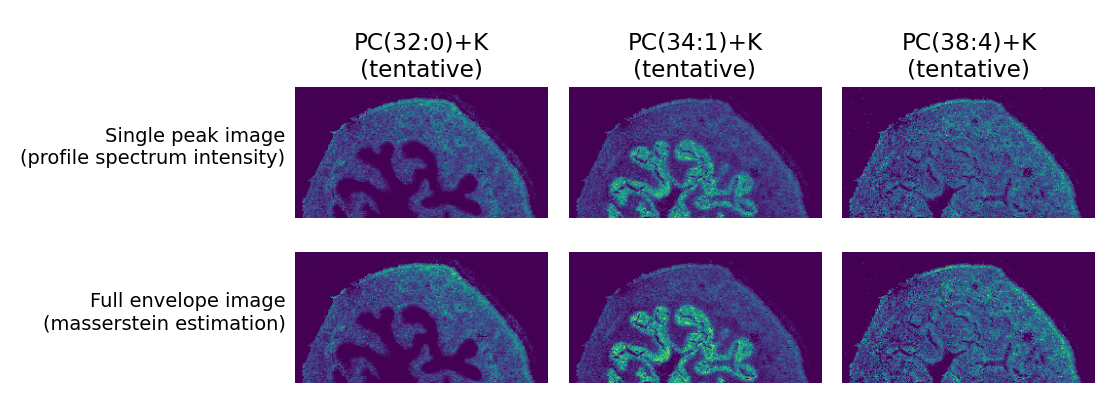

/tmp/ipykernel_55523/4080630301.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 1)
/tmp/ipykernel_55523/4080630301.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 4)
/tmp/ipykernel_55523/4080630301.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 1+i)
/tmp/ipykernel_55523/4080630301.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 4+i)


Correlation for PC(32:0)+K 0.9852654951414421
Correlation for PC(34:1)+K 0.9812464952943333
Correlation for PC(38:4)+K 0.9631382750343598


In [124]:
plt.subplots(2, 4, figsize=(8, 3))
plt.subplot(2, 3, 1)
plt.text(-10, 40, 'Single peak image\n(profile spectrum intensity)',
        ha='right',
        va='top')
plt.subplot(2, 3, 4)
plt.text(-10, 40, 'Full envelope image\n(masserstein estimation)', 
        ha='right',
        va='top')

for i, lipid_id in enumerate(test_lipid_ids_per_image['bladder']):
    test_masserstein = regression_images['bladder'][...,lipid_id]
    test_intensity = single_peak_images['bladder'][...,lipid_id]
    print('Correlation for', test_lipid_names[i], np.corrcoef(test_masserstein.flatten(), test_intensity.flatten())[0,1])
    plt.subplot(2, 3, 1+i)
    plt.title(test_lipid_names[i] + '\n(tentative)')
    plt.imshow(test_intensity)
    plt.axis('off')
    plt.subplot(2, 3, 4+i)
    plt.imshow(test_masserstein)
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/lipid_quantification/bladder_selected_images.png', dpi=300)

In [121]:
np.corrcoef(test_masserstein.flatten(), test_intensity.flatten())

array([[1.        , 0.96313828],
       [0.96313828, 1.        ]])

<IPython.core.display.Javascript object>


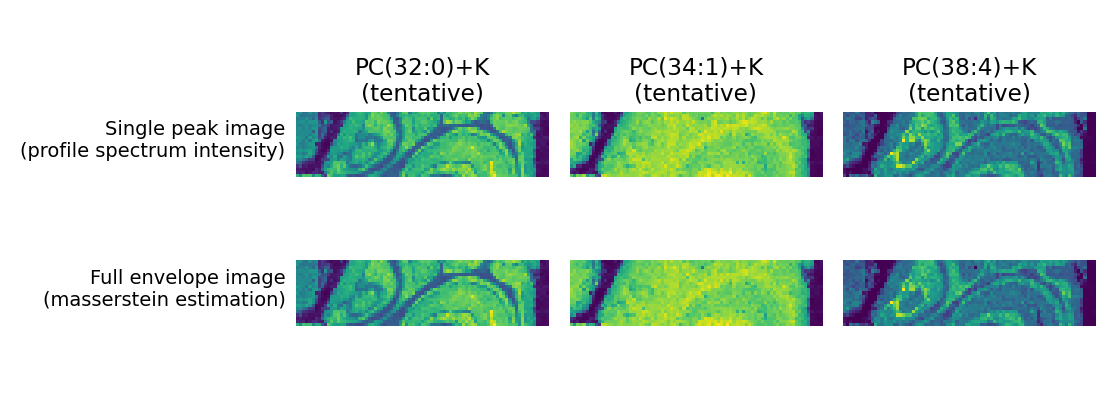

/tmp/ipykernel_55523/2506399641.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 1)
/tmp/ipykernel_55523/2506399641.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 4)
/tmp/ipykernel_55523/2506399641.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 1+i)
/tmp/ipykernel_55523/2506399641.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 4+i)


Correlation for PC(32:0)+K 0.9992910700259277
Correlation for PC(34:1)+K 0.998433381455824
Correlation for PC(38:4)+K 0.9958715465738092


In [125]:
plt.subplots(2, 4, figsize=(8, 3))
plt.subplot(2, 3, 1)
plt.text(-4, 2, 'Single peak image\n(profile spectrum intensity)',
        ha='right',
        va='top')
plt.subplot(2, 3, 4)
plt.text(-4, 2, 'Full envelope image\n(masserstein estimation)', 
        ha='right',
        va='top')

for i, lipid_id in enumerate(test_lipid_ids_per_image['cerebellum']):
    test_masserstein = regression_images['cerebellum'][...,lipid_id]
    test_intensity = single_peak_images['cerebellum'][...,lipid_id]
    print('Correlation for', test_lipid_names[i], np.corrcoef(test_masserstein.flatten(), test_intensity.flatten())[0,1])
    plt.subplot(2, 3, 1+i)
    plt.title(test_lipid_names[i] + '\n(tentative)')
    plt.imshow(test_intensity)
    plt.axis('off')
    plt.subplot(2, 3, 4+i)
    plt.imshow(test_masserstein)
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/lipid_quantification/cerebellum_selected_images.png', dpi=300)

## Saving the results

Save the estimation results:

In [127]:
regression_images['cerebellum'].dump('cerebellum_regression_images.dmp')
regression_images['bladder'].dump('bladder_regression_images.dmp')

Save the peak intensities:

In [128]:
single_peak_images['cerebellum'].dump('cerebellum_single_peak_images.dmp')
single_peak_images['bladder'].dump('bladder_single_peak_images.dmp')

We'll now generate and save ion images for each lipid, obtained from peak intensities and estimated quantities.  

## Comparing the estimated spatial distributions

In [16]:
masserstein_coordinates = {n: [] for n in image_names}
masserstein_estimation = {n: [] for n in image_names}
lipid_formulas = {n: [] for n in image_names}
for n in image_names:
    with open(n + '_masserstein_quantification.tsv') as h:
        header = next(h)
        header = header.strip().split('\t')
        lipid_formulas[n] = header[2:]
        for l in h:
            l = l.strip().split('\t')
            masserstein_coordinates[n].append((int(l[0]), int(l[1])))
            masserstein_estimation[n].append(list(map(float, l[2:])))
    masserstein_coordinates[n] = np.array(masserstein_coordinates[n])
    masserstein_estimation[n] = np.array(masserstein_estimation[n])


<IPython.core.display.Javascript object>


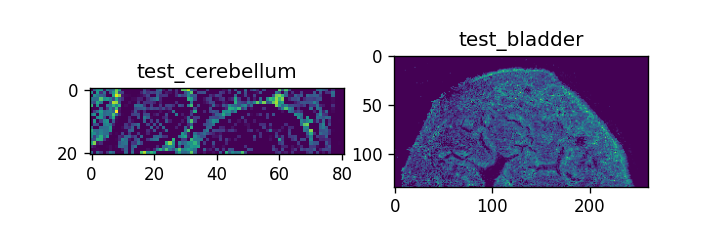

In [18]:
test_cerebellum = np.zeros(image_shapes['cerebellum'])
test_bladder = np.zeros(image_shapes['bladder'])

for i, l in enumerate(masserstein_coordinates['cerebellum']):
    test_cerebellum[l[0], l[1]] = masserstein_estimation['cerebellum'][i, 9]    
for i, l in enumerate(masserstein_coordinates['bladder']):
    test_bladder[l[0], l[1]] = masserstein_estimation['bladder'][i, 9]    
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.title('test_cerebellum')
plt.imshow(test_cerebellum)
plt.subplot(122)
plt.title('test_bladder')
plt.imshow(test_bladder)
plt.show()

In [16]:
signal_correlations = {'cerebellum': [], 'bladder': []}
for n in image_names:
    # in case we only want to analyze a subset of pixels:
    massr_crd_list = [tuple(x) for x in masserstein_coordinates[n]]
    intsy_crd_list = [tuple(x) for x in intensity_coordinates[n]]
    common_pixels = list(set(massr_crd_list) & set(intsy_crd_list))
    idx_in_intsy = [intsy_crd_list.index(x) for x in common_pixels]
    idx_in_massr = [massr_crd_list.index(x) for x in common_pixels]
    for lipid_id in range(len(lipid_spectra[n])):
        intsy_vec = [intensities[n][x, lipid_id] for x in idx_in_intsy]
        massr_vec = [masserstein_estimation[n][x, lipid_id] for x in idx_in_massr]
        cor = np.corrcoef(intsy_vec, massr_vec)
        signal_correlations[n].append(cor[0,1])

<IPython.core.display.Javascript object>


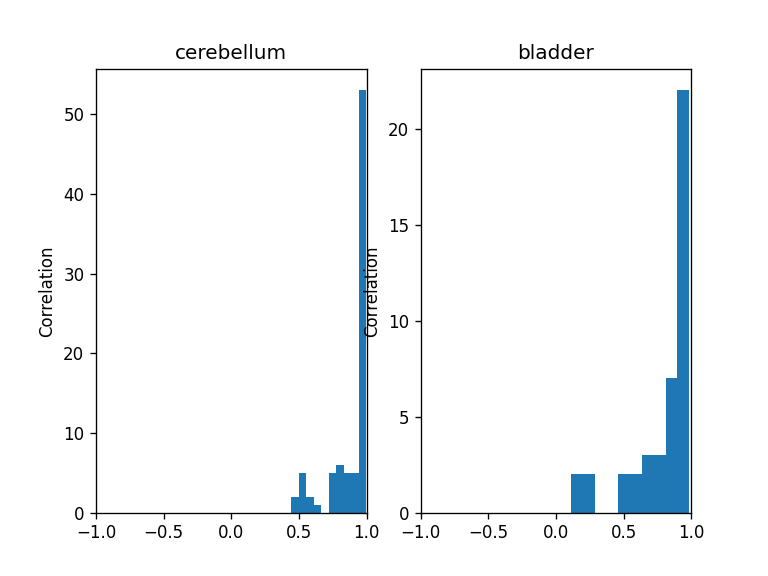

In [17]:
plt.figure()
plt.subplot(121)
plt.title(image_names[0])
plt.hist(signal_correlations[image_names[0]])
plt.ylabel('Correlation')
plt.xlim(-1, 1)
plt.subplot(122)
plt.title(image_names[1])
plt.hist(signal_correlations[image_names[1]])
plt.ylabel('Correlation')
plt.xlim(-1, 1)
plt.show()

In [18]:
np.argmin(signal_correlations['bladder'])

32

<IPython.core.display.Javascript object>


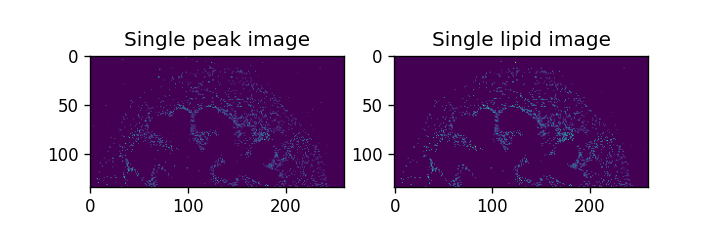

In [19]:
test_name = 'bladder'
test_lipid_id = 30
test_masserstein = np.zeros(image_shapes[test_name])
test_intensity = np.zeros(image_shapes[test_name])
for i, l in enumerate(masserstein_coordinates[test_name]):
    test_masserstein[l[0], l[1]] = masserstein_estimation[test_name][i, test_lipid_id]    
for i, l in enumerate(intensity_coordinates[test_name]):
    test_intensity[l[0], l[1]] = intensities[test_name][i, test_lipid_id]

plt.figure(figsize=(6,2))
plt.subplot(121)
plt.title('Single peak image')
plt.imshow(test_intensity)
plt.subplot(122)
plt.title('Single lipid image')
plt.imshow(test_masserstein)
plt.show()

## Analyzing the most common lipid classes

In [23]:
lipid_total_signals = {n: np.sum(masserstein_estimation[n], axis=0) for n in image_names}

In [30]:
annotated_subclasses = {n: [formula_to_subclass[f] for f in lipid_formulas[n]] for n in image_names}

In [54]:
subclass_total_signals = {n: {} for n in image_names}
for n in image_names:
    for i, f in enumerate(lipid_formulas[n]):
        sbc = formula_to_subclass_short[f]
        try:
            subclass_total_signals[n][sbc] += lipid_total_signals[n][i]
        except KeyError:
            subclass_total_signals[n][sbc] = lipid_total_signals[n][i]
    summed_signals = sum(subclass_total_signals[n].values())
    for sbc in subclass_total_signals[n]:
        subclass_total_signals[n][sbc] /= summed_signals
    subclass_total_signals[n] = sorted(subclass_total_signals[n].items(), key=lambda x: x[1], reverse=True)

In [66]:
subclass_total_signals

{'cerebellum': [('GP01/GP02', 0.5757498532214648),
  ('GP10', 0.26934393307787896),
  ('SP03', 0.08681343818677469),
  ('GP03', 0.03660296926332466),
  ('GP01', 0.01051171891169834),
  ('SP05', 0.009002413380646048),
  ('GP04', 0.007878280792980386),
  ('GP20', 0.0009954729865622829),
  ('GP01/GP02/GP20', 0.0009837252979429598),
  ('GP03/GP20', 0.0009097259673362564),
  ('GP02', 0.0008162262253912177),
  ('SP02', 0.00039224268799928976)],
 'bladder': [('GP01/GP02', 0.6709836160837115),
  ('SP03', 0.25937001879569627),
  ('GP10', 0.04318056400918281),
  ('GP04', 0.012991407495416387),
  ('SP05', 0.005571353810821087),
  ('GP01/GP02/GP20', 0.0035834456407945717),
  ('GP01', 0.0023658928977174044),
  ('GP03', 0.0019537012666599953)]}

In [65]:
subclass_labeling

{'GP00': 'Other Glycerophospholipids [GP00]',
 'GP01': 'Glycerophosphocholines [GP01]',
 'GP02': 'Glycerophosphoethanolamines [GP02]',
 'GP03': 'Glycerophosphoserines [GP03]',
 'GP04': 'Glycerophosphoglycerols [GP04]',
 'GP05': 'Glycerophosphoglycerophosphates [GP05]',
 'GP06': 'Glycerophosphoinositols [GP06]',
 'GP07': 'Glycerophosphoinositol monophosphates [GP07]',
 'GP08': 'Glycerophosphoinositol bisphosphates [GP08]',
 'GP09': 'Glycerophosphoinositol trisphosphates [GP09]',
 'GP10': 'Glycerophosphates [GP10]',
 'GP11': 'Glyceropyrophosphates [GP11]',
 'GP12': 'Glycerophosphoglycerophosphoglycerols [GP12]',
 'GP13': 'CDP-Glycerols [GP13]',
 'GP14': 'Glycosylglycerophospholipids [GP14]',
 'GP15': 'Glycerophosphoinositolglycans [GP15]',
 'GP16': 'Glycerophosphonocholines [GP16]',
 'GP17': 'Glycerophosphonoethanolamines [GP17]',
 'GP18': 'Di-glycerol tetraether phospholipids (caldarchaeols) [GP18]',
 'GP19': 'Glycerol-nonitol tetraether phospholipids [GP19]',
 'GP20': 'Oxidized glycero

## Verifying the bladder annotation 

In [67]:
SM34_1 = 'C39H79N2O6P'
PC32_0 = 'C40H80NO8P'
PC34_1 = 'C42H82NO8P'
PC38_4 = 'C46H84NO8P'

In [70]:
lipid_formulas['bladder'].index(SM34_1)

29

In [71]:
lipid_total_signals['bladder'][29]

800.6596412730108

In [72]:
lipid_formulas['bladder'].index(PC32_0)

16

In [73]:
lipid_total_signals['bladder'][16]

589.8828214646949

In [74]:
lipid_formulas['bladder'].index(PC34_1)

21

In [75]:
lipid_total_signals['bladder'][21]

1099.7496721897598

In [76]:
lipid_formulas['bladder'].index(PC38_4)

9

In [77]:
lipid_total_signals['bladder'][9]

510.63573255739675

<IPython.core.display.Javascript object>


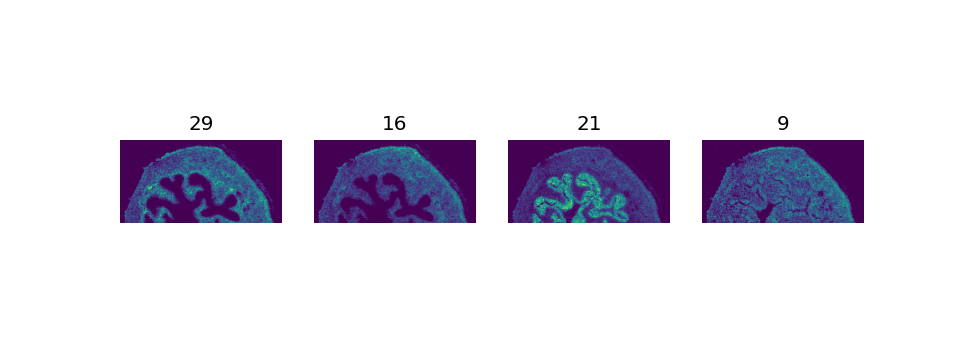

In [82]:
selected_images = [np.zeros(image_shapes['bladder']) for _ in range(4)]
lipids_to_plot = [29, 16, 21, 9]
 
for i, l in enumerate(masserstein_coordinates['bladder']):
    for j, lid in enumerate(lipids_to_plot):
        selected_images[j][l[0], l[1]] = masserstein_estimation['bladder'][i, lid]    
plt.figure(figsize=(8,3))
for j, lid in enumerate(lipids_to_plot):
    plt.subplot(141 + j)
    plt.title(lid)
    plt.imshow(selected_images[j])
    plt.axis('off')
plt.show()

## Code remnants

Deconvolution of selected pixels:

In [2]:
# masserstein_estimation = {n : [] for n in image_names}
# masserstein_coordinates = {n : [] for n in image_names}
# for n in image_names:
#     print('Processing image:', n, '(centroid mode)')
#     s = time()
#     for idx, (xcoord,ycoord,zcoord) in enumerate(centroided_images[n].coordinates):
#         if not idx % 10000:
#             print('Processing pixel number', idx)
#         mz, intsy = centroided_images[n].getspectrum(idx)
#         total_tic = np.sum(intsy)
#         selected_range = (analyzed_mass_range[0] <= mz)*(mz <= analyzed_mass_range[1])
#         mz = mz[selected_range]
#         intsy = intsy[selected_range]
#         local_tic = np.sum(intsy)
# #         selected_peaks = intsy >= 1e-4*max(intsy)
# #         mz = mz[selected_peaks]
# #         intsy = intsy[selected_peaks]
#         pixel_spectrum = Spectrum(confs=list(zip(mz, intsy)))
#         pixel_spectrum.normalize()
#         regression = estimate_proportions(pixel_spectrum, lipid_spectra[n], 
#                                           MTD=MTD, MTD_th=MTD_th, MDC=1e-06, MMD=0.1, progress=False)
#         props = np.array(regression['proportions'])
#         # We want to rescale the proportions so that it's as if they were calculated 
#         # on full spectra (i.e. we correct for restricting spectra to the local mass range)
#         rescaled_props = props*local_tic / total_tic 
#         masserstein_estimation[n].append(rescaled_props)
#         masserstein_coordinates[n].append((ycoord-1, xcoord-1))
#     e = time()
#     print('Regression time:', e-s)
# masserstein_estimation = {n : np.array(masserstein_estimation[n]) for n in image_names}
# masserstein_coordinates = {n : np.array(masserstein_coordinates[n]) for n in image_names}

In [24]:
# intensities = {n : [] for n in image_names}
# intensity_coordinates = {n : [] for n in image_names}
# for n in image_names:
#     print('Processing image:', n, '(profile mode)')
#     monoisotopic_masses = [s.confs[0][0] for s in lipid_spectra[n]]
#     s = time()
#     for idx, (xcoord,ycoord,zcoord) in enumerate(profile_images[n].coordinates):
#         if not idx % 10000:
#             print('Processing pixel number', idx)
#         mz, intsy = profile_images[n].getspectrum(idx)
#         intsy = intsy / np.trapz(intsy, mz)  # note: we normalize BEFORE restricting to local mass range
#         # Restricting is optional in this technique 
#         #selected_range = (analyzed_mass_range[0] <= mz)*(mz <= analyzed_mass_range[1])
#         #mz = mz[selected_range]
#         #intsy = intsy[selected_range]
#         peak_intensities = np.interp(monoisotopic_masses, mz, intsy)
#         intensities[n].append(peak_intensities)
#         intensity_coordinates[n].append((ycoord-1, xcoord-1))
#     e = time()
#     print('Regression time:', e-s)
# intensities = {n : np.array(intensities[n]) for n in image_names}
# intensity_coordinates = {n : np.array(intensity_coordinates[n]) for n in image_names}

Processing image: cerebellum (profile mode)
Processing pixel number 0
Regression time: 0.09274768829345703
Processing image: bladder (profile mode)
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000
Regression time: 0.9651458263397217


In [ ]:
# test_name = 'bladder'
# test_lipid_id = 25
# test_masserstein = np.zeros(image_shapes[test_name])
# test_intensity = np.zeros(image_shapes[test_name])
# for i, l in enumerate(masserstein_coordinates[test_name]):
#     test_masserstein[l[0], l[1]] = masserstein_estimation[test_name][i, test_lipid_id]
# for i, l in enumerate(intensity_coordinates[test_name]):
#     test_intensity[l[0], l[1]] = intensities[test_name][i, test_lipid_id]
# plt.figure(figsize=(8,3))
# plt.subplot(121)
# plt.axis('off')
# plt.title('Single peak image')
# plt.imshow(test_intensity)
# plt.subplot(122)
# plt.axis('off')
# plt.title('Single lipid image')
# plt.imshow(np.log(0.001+test_masserstein))
# plt.tight_layout()
# plt.show()

In [ ]:
# test_name = 'cerebellum'
# test_lipid_id = 9
# test_masserstein = np.zeros(image_shapes[test_name])
# test_intensity = np.zeros(image_shapes[test_name])
# for i, l in enumerate(masserstein_coordinates[test_name]):
#     test_masserstein[l[0], l[1]] = masserstein_estimation[test_name][i, test_lipid_id]
# for i, l in enumerate(intensity_coordinates[test_name]):
#     test_intensity[l[0], l[1]] = intensities[test_name][i, test_lipid_id]
# plt.figure(figsize=(6,2))
# plt.subplot(121)
# plt.title('Single peak image')
# plt.imshow(test_intensity)
# plt.subplot(122)
# plt.title('Single lipid image')
# plt.imshow(test_masserstein)
# plt.show()

In [126]:
# for n in image_names:
#     frms = lipid_formulas[n]
#     crd = masserstein_coordinates[n]
#     est = masserstein_estimation[n]
#     with open(n + '_masserstein_quantification.tsv', 'w') as h:
#         h.write('X\tY\t' + '\t'.join(frms) + '\n')
#         for i in range(crd.shape[0]):
#             h.write(str(crd[i, 0]) + '\t' + str(crd[i,1]) + '\t' + '\t'.join(list(map(str, est[i]))) + '\n')


NameError: name 'masserstein_coordinates' is not defined

In [ ]:
# for n in image_names:
#     frms = lipid_formulas[n]
#     crd = intensity_coordinates[n]
#     est = intensities[n]
#     with open(n + '_single_peak_intensities.tsv', 'w') as h:
#         h.write('X\tY\t' + '\t'.join(frms) + '\n')
#         for i in range(crd.shape[0]):
#             h.write(str(crd[i, 0]) + '\t' + str(crd[i,1]) + '\t' + '\t'.join(list(map(str, est[i]))) + '\n')


In [ ]:
# for n in image_names:
#     for lipid_id, lipid_sp in enumerate(lipid_spectra[n]):
#         intsy_image = np.zeros(image_shapes[n])
#         decon_image = np.zeros(image_shapes[n])
#         for i, l in enumerate(intensity_coordinates[n]):
#             intsy_image[l[0], l[1]] = intensities[n][i,lipid_id]
#         for i, l in enumerate(masserstein_coordinates[n]):
#             decon_image[l[0], l[1]] = masserstein_estimation[n][i,lipid_id]
        
#         plt.figure()# figsize=(0.1*image_shapes[n][1], 0.1*2*image_shapes[n][0]))
#         plt.subplot(121)
#         plt.title(str(lipid_id) + ' peak at %.2f' % lipid_sp.confs[0][0])
#         plt.imshow(intsy_image)
#         plt.axis('off')
#         plt.subplot(122)
#         plt.title(str(lipid_id) + ' masserstein')
#         plt.imshow(decon_image)
#         plt.axis('off')
#         plt.tight_layout()
#         plt.savefig('Figs/' + n + '_ion_images/%i.png' % lipid_id, dpi=300)
#         plt.close()